In [1]:
import warnings
from xml.etree.ElementInclude import include
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from statistics import mean
import numpy as np
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
plt.style.use('ggplot')

matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

import seaborn as sns


In [2]:
df = pd.read_csv("../data/telcom.csv")

In [3]:
experience_df = pd.DataFrame({'customer':df['MSISDN/Number'],
                      'sessions_frequency':df['Bearer Id'],
                      'duration':df['Dur. (ms)'],
                        'handset':df['Handset Type']})
experience_df['rtt'] = df['Avg RTT DL (ms)']+df['Avg RTT UL (ms)']
experience_df['tp'] = df['Avg Bearer TP DL (kbps)']+df['Avg Bearer TP UL (kbps)']
experience_df['tcp'] = df['TCP DL Retrans. Vol (Bytes)']+df['TCP UL Retrans. Vol (Bytes)']
experience_df.head(4)

,customer,sessions_frequency,duration,handset,rtt,tp,tcp
0,3.366496e+10,1.311450e+19,1823652.0,Samsung Galaxy A5 Sm-A520F,47.0,67.0,NaN
1,3.368185e+10,1.311450e+19,1365104.0,Samsung Galaxy J5 (Sm-J530),70.0,42.0,NaN
2,3.376063e+10,1.311450e+19,1361762.0,Samsung Galaxy A8 (2018),NaN,15.0,NaN
3,3.375034e+10,1.311450e+19,1321509.0,undefined,NaN,88.0,NaN


In [4]:
def generate_pipeline(type_="numeric",x=1):
    pipeline = None
    if type_ == "numeric":
        pipeline = Pipeline(steps=[
            ('impute', SimpleImputer(strategy='mean')),
            ('scale', MinMaxScaler())
        ])
    elif type_ == "categorical":
        pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
        ])
    else:
        pipeline = np.zeros(x)
    return pipeline

In [5]:
def generate_transformation(pipeline,df,type_,value):
    transformation = None
    if type_=="numeric":
        transformation=pipeline.fit_transform(df.select_dtypes(include=value))
    elif type_ == "categorical":
        transformation=pipeline.fit_transform(df.select_dtypes(exclude=value))
    return transformation

In [6]:
numeric_pipeline = generate_pipeline("numeric")
assert isinstance(numeric_pipeline,Pipeline)

In [7]:
categorical_pipeline = generate_pipeline("categorical")
assert isinstance(numeric_pipeline,Pipeline)

In [8]:
def store_features(df,type_,value):
    features = [None]
    if type_ == "numeric":
        features = df.select_dtypes(include=value).columns.tolist()
    elif type_ == "categorical":
        features = df.select_dtypes(exclude=value).columns.tolist()
    return features


In [9]:
categorical_features = store_features(experience_df,"categorical","number")

In [10]:
numerical_features = store_features(experience_df,"numeric","number")

In [11]:
def handle_missing_values_numeric(df,features):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mean
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    for key in features:
        df[key] = df[key].fillna(df[key].mean())
    return missing_percentage, df

In [12]:
handle_missing_values_numeric(experience_df,numerical_features)

(12.38,
             customer  sessions_frequency      duration  \
 0       3.366496e+10        1.311450e+19  1.823652e+06   
 1       3.368185e+10        1.311450e+19  1.365104e+06   
 2       3.376063e+10        1.311450e+19  1.361762e+06   
 3       3.375034e+10        1.311450e+19  1.321509e+06   
 4       3.369980e+10        1.311450e+19  1.089009e+06   
 ...              ...                 ...           ...   
 149996  3.365069e+10        7.277830e+18  8.123000e+04   
 149997  3.366345e+10        7.349880e+18  9.797000e+04   
 149998  3.362189e+10        1.311450e+19  9.824900e+04   
 149999  3.361962e+10        1.311450e+19  9.791000e+04   
 150000  4.188282e+10        1.013887e+19  1.046086e+05   
 
                             handset         rtt            tp           tcp  
 0        Samsung Galaxy A5 Sm-A520F   47.000000     67.000000  2.571697e+07  
 1       Samsung Galaxy J5 (Sm-J530)   70.000000     42.000000  2.571697e+07  
 2          Samsung Galaxy A8 (2018)  127.024

In [13]:
def handle_missing_values_categorical(df,features):
    """
    this algorithm does the following
    - remove columns with x percentage of missing values
    - fill the missing values with the mode
    returns:
        - df
        - percentage of missing values
    """
    missing_percentage = round((df.isnull().sum().sum()/\
            reduce(lambda x, y: x*y, df.shape))*100,2)
    for key in features:
        df[key] = df[key].fillna(df[key].mode()[0])
    return missing_percentage, df

In [14]:
handle_missing_values_categorical(experience_df,categorical_features)

(0.05,
             customer  sessions_frequency      duration  \
 0       3.366496e+10        1.311450e+19  1.823652e+06   
 1       3.368185e+10        1.311450e+19  1.365104e+06   
 2       3.376063e+10        1.311450e+19  1.361762e+06   
 3       3.375034e+10        1.311450e+19  1.321509e+06   
 4       3.369980e+10        1.311450e+19  1.089009e+06   
 ...              ...                 ...           ...   
 149996  3.365069e+10        7.277830e+18  8.123000e+04   
 149997  3.366345e+10        7.349880e+18  9.797000e+04   
 149998  3.362189e+10        1.311450e+19  9.824900e+04   
 149999  3.361962e+10        1.311450e+19  9.791000e+04   
 150000  4.188282e+10        1.013887e+19  1.046086e+05   
 
                             handset         rtt            tp           tcp  
 0        Samsung Galaxy A5 Sm-A520F   47.000000     67.000000  2.571697e+07  
 1       Samsung Galaxy J5 (Sm-J530)   70.000000     42.000000  2.571697e+07  
 2          Samsung Galaxy A8 (2018)  127.0248

Task 3. 1 - Aggregate, per customer, the following information (treat missing & outliers by replacing by the mean or the mode of the corresponding variable):
Average TCP retransmission
Average RTT
Handset type
Average throughput


In [15]:
def aggregation_cols(df,col_1,col_2,ty="numerical",trim=False):
    if ty == "numerical":
        grouped = df.groupby(col_1).agg({col_2: [min, max, mean]}) 
        grouped.columns = ["_".join(x) for x in grouped.columns.ravel()]
    else:
        grouped = df.groupby([col_1])[col_2].agg(pd.Series.mode)
    if trim:
        return grouped.describe()
    return grouped

Task 3.2 - Compute & list 10 of the top, bottom and most frequent:
TCP values in the dataset. 
RTT values in the dataset.


In [16]:
tcp_aggregation = aggregation_cols(experience_df,'customer','tcp')
top_customers_tcp = tcp_aggregation.sort_values(by='tcp_max', ascending=False)
top_customers_tcp.head(10)

,tcp_min,tcp_max,tcp_mean
customer,,,
3.366045e+10,1.861868e+07,4.344116e+09,2.181367e+09
3.369858e+10,4.301477e+09,4.301477e+09,4.301477e+09
3.376211e+10,3.268309e+08,4.294432e+09,2.310631e+09
3.365872e+10,1.109669e+07,4.291465e+09,1.438251e+09
3.365871e+10,4.288121e+09,4.288121e+09,4.288121e+09
3.366469e+10,6.390463e+06,4.275492e+09,9.130163e+08
3.366491e+10,4.268647e+09,4.268647e+09,4.268647e+09
3.376233e+10,1.959403e+06,4.261616e+09,2.131788e+09
3.365828e+10,3.435268e+06,4.260174e+09,9.562750e+08


In [17]:
rtt_aggregation = aggregation_cols(experience_df,'customer','rtt')
top_customers_rtt = rtt_aggregation.sort_values(by='rtt_max', ascending=False)
top_customers_rtt.head(10)

,rtt_min,rtt_max,rtt_mean
customer,,,
3.366232e+10,96924.0,96924.0,96924.000000
3.366087e+10,29.0,64641.0,32335.000000
4.188282e+10,19.0,55812.0,309.155397
3.368369e+10,54848.0,54848.0,54848.000000
3.376094e+10,27278.0,27278.0,27278.000000
3.360679e+10,26300.0,26300.0,26300.000000
3.369855e+10,20099.0,25922.0,23010.500000
3.367182e+10,25715.0,25715.0,25715.000000
3.378187e+10,25388.0,25388.0,25388.000000


In [18]:
tp_aggregation = aggregation_cols(experience_df,'customer','tp')
top_customers_tp = tp_aggregation.sort_values(by='tp_max', ascending=False)
top_customers_tp.head(10)

,tp_min,tp_max,tp_mean
customer,,,
3.366117e+10,37641.0,382262.0,156073.333333
3.367251e+10,2.0,313244.0,128630.500000
3.369817e+10,2.0,304299.0,103132.833333
3.366662e+10,122.0,300546.0,150334.000000
3.365991e+10,283931.0,283931.0,283931.000000
3.366566e+10,249209.0,281144.0,265176.500000
3.365169e+10,86.0,277152.0,138619.000000
3.366856e+10,109.0,276205.0,138157.000000
3.366549e+10,101.0,274052.0,78734.166667


In [19]:
handset_aggregation = aggregation_cols(experience_df,'customer','handset',ty="categorical")
top_handsets = pd.DataFrame(handset_aggregation)
top_handsets.head(10)

,handset
customer,
3.360100e+10,Huawei P20 Lite Huawei Nova 3E
3.360100e+10,Apple iPhone 7 (A1778)
3.360100e+10,undefined
3.360101e+10,Apple iPhone 5S (A1457)
3.360101e+10,Apple iPhone Se (A1723)
3.360101e+10,Samsung Galaxy A8 (2018)
3.360101e+10,Huawei Mate 10 Pro Porsche Design Huawei Mate 10
3.360101e+10,Samsung Galaxy S8 Plus (Sm-G955F)
3.360101e+10,undefined


Task 3.3 - Compute & report:
The distribution of the average throughput  per handset type and provide interpretation for your findings.
The average TCP retransmission view per handset type and provide interpretation for your findings.


In [20]:
tp_aggregation = aggregation_cols(experience_df,'handset','tp')
top_handset_tp = tp_aggregation.sort_values(by='tp_mean', ascending=False)
top_handset_tp.head(10)

,tp_min,tp_max,tp_mean
handset,,,
Huawei B715S-23C,35248.0,170708.0,108994.230769
New-Bund Technol. Mix 2,105211.0,105211.0,105211.000000
Lg G6+,100135.0,100135.0,100135.000000
Zyxel Communicat. Sbg3600,97351.0,97351.0,97351.000000
Huawei Y9 2019,91739.0,91739.0,91739.000000
Xiaomi Communica. M1902F1G,36553.0,179453.0,85613.666667
Spa Condor Elect. Allure M2,81712.0,86911.0,84311.500000
Ovvi-Cellphone T. Echo,78953.0,78953.0,78953.000000
Huawei Pele,78381.0,78381.0,78381.000000


In [21]:
tcp_aggregation = aggregation_cols(experience_df,'handset','tcp')
top_handset_tcp = tcp_aggregation.sort_values(by='tcp_mean', ascending=False)
top_handset_tcp.head(10)

,tcp_min,tcp_max,tcp_mean
handset,,,
Huawei Bln-Al10,3.291746e+08,3.291746e+08,3.291746e+08
Asustek Asus Zenfone Selfie Zd551Kl,4.085478e+07,6.024618e+08,3.216583e+08
Samsung Galaxy Tab S3 (Sm-T825),7.621800e+04,1.011812e+09,2.077707e+08
Huawei E5776S-32,1.085037e+07,1.387672e+09,1.722301e+08
Apple iPad Pro (A1652),2.571697e+07,7.015312e+08,1.383527e+08
Samsung Galaxy J8 2018,1.157583e+08,1.157583e+08,1.157583e+08
Dynamic Tech Hol. D-Mobile I3 I5 I7 I8 I9,2.571697e+07,2.683127e+08,1.065822e+08
Xiaomi Communica. Mi 6,5.231980e+06,1.455422e+08,7.538708e+07
Huawei E5573,5.427000e+03,3.148243e+09,6.986943e+07


Task 3.4 - Using the experience metrics above, perform 
a k-means clustering (where k = 3) to segment users into groups of experiences 
and provide a brief description of each cluster. 
(The description must define each group based on your understanding of the data)


In [22]:
pca = PCA(2)
experience_df_ = experience_df[numerical_features]

#Transform the data
df_ = pca.fit_transform(experience_df_)
 
df_.shape

(150001, 2)

In [23]:
kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=42)
y_pred = kmeans.fit_predict(df_)
experience_df['y_pred'] = y_pred

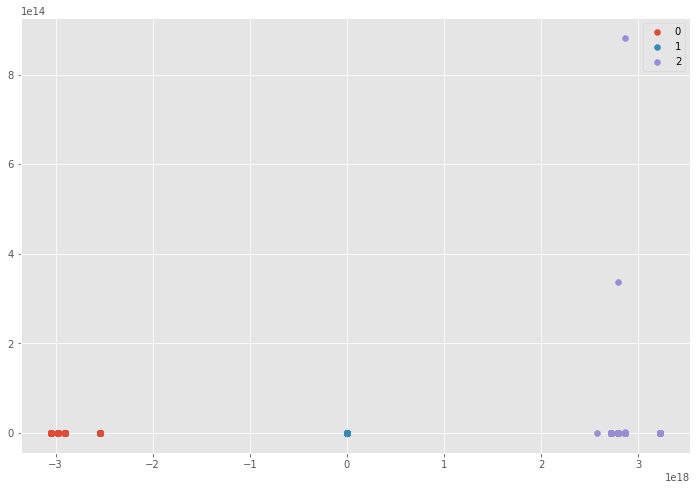

In [24]:
labels_ = np.unique(y_pred)
 
#plotting the results:
 
for i in labels_:
    plt.scatter(df_[y_pred == i , 0] , df_[y_pred == i , 1] , label = i)
plt.legend()
plt.show()

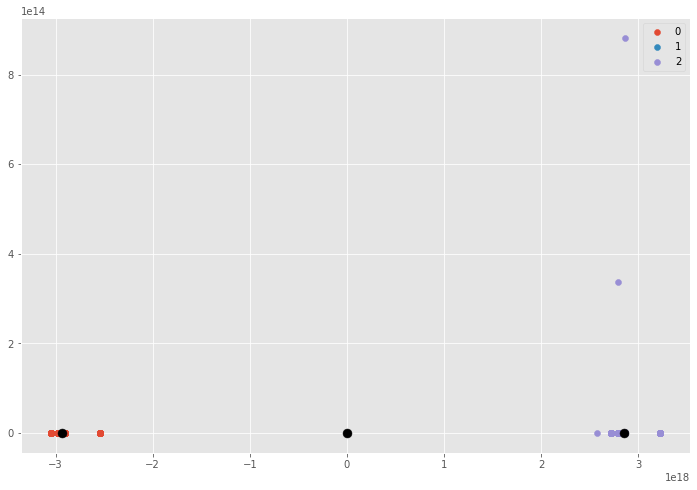

In [25]:
centroids = kmeans.cluster_centers_
labels_ = np.unique(y_pred)
 
#plotting the results:
 
for i in labels_:
    plt.scatter(df_[y_pred == i , 0] , df_[y_pred == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

In [26]:
experience_score=[]
for i in df_:
    experience_score.append(euclidean_distances([i.tolist()],[centroids[0].tolist()]))

In [27]:
experience_pipeline = generate_pipeline(type_="numeric")
experience = generate_transformation(experience_pipeline,
                                 pd.DataFrame(np.squeeze(experience_score)[()]),"numeric","number")

In [28]:
experience_df['experience_score']=experience

In [29]:
experience_df.to_csv("../data/experience.csv")

In [30]:
#Task 4.2 - Consider the average of both engagement & experience scores as  
# the satisfaction score & report the top 10 satisfied customer 

In [31]:
engagement = pd.read_csv("../data/applications.csv")
experience_ = pd.read_csv("../data/experience.csv")
satisfaction_df = pd.DataFrame({"customer":experience_["customer"],
                                "engagement_score":engagement["engagement_score"],
                                "experience_score":experience_["experience_score"]})
satisfaction_df["satisfaction_sum"] = satisfaction_df["engagement_score"]+satisfaction_df["experience_score"]
satisfaction_df["satisfaction_score"] = satisfaction_df["satisfaction_sum"]/2
satisfaction_df.sort_values(by="satisfaction_score",ascending=False).head(10)

,customer,engagement_score,experience_score,satisfaction_sum,satisfaction_score
75075,3.366884e+10,1.0,1.0,2.0,1.0
26430,3.366576e+10,1.0,1.0,2.0,1.0
26398,3.366697e+10,1.0,1.0,2.0,1.0
26971,3.367086e+10,1.0,1.0,2.0,1.0
31765,3.365945e+10,1.0,1.0,2.0,1.0
28925,3.363106e+10,1.0,1.0,2.0,1.0
53202,3.369831e+10,1.0,1.0,2.0,1.0
132493,3.367724e+10,1.0,1.0,2.0,1.0
130788,3.369988e+10,1.0,1.0,2.0,1.0
132245,3.366312e+10,1.0,1.0,2.0,1.0


Task 4.3 - Build a regression model of your choice to predict the satisfaction score of a customer

In [32]:
y = satisfaction_df['satisfaction_score']
x = satisfaction_df[['engagement_score','experience_score']]
x = sm.add_constant(x)
model = sm.OLS(y, x).fit()
satisfaction_df['satisfaction_prediction_scores'] = model.predict(x)
result =  model.summary()
result

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     satisfaction_score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.244e+29
Date:                Fri, 13 May 2022   Prob (F-statistic):               0.00
Time:                        08:45:34   Log-Likelihood:             4.2338e+06
No. Observations:              150001   AIC:                        -8.468e+06
Df Residuals:                  149998   BIC:                        -8.468e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.157e-13   4.03e-15    -53.570      0.000   -2.24e-13   -2.08e-13
engagement_score     0.5000   4.42e-15   1.13e+14      0.000       0.500       0.500
experience_score     0.5000   7.46e-16    6.7e+14      0.000       0.500       0.500
==============================================================================
Omnibus:                   525242.135   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23840.318
Skew:                           0.008   Prob(JB):                         0.00
Kurtosis:                       1.047   Cond. No.                         24.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Task 4.4 - Run a k-means (k=2) on the engagement & the experience score . 


In [33]:
pca = PCA(2)
sat = satisfaction_df[['engagement_score','experience_score']]

#Transform the data
df_ = pca.fit_transform(sat)
 
df_.shape
kmeans = KMeans(init="random",n_clusters=2,n_init=10,max_iter=300,random_state=42)
y_pred = kmeans.fit_predict(df_)
satisfaction_df['class'] = y_pred

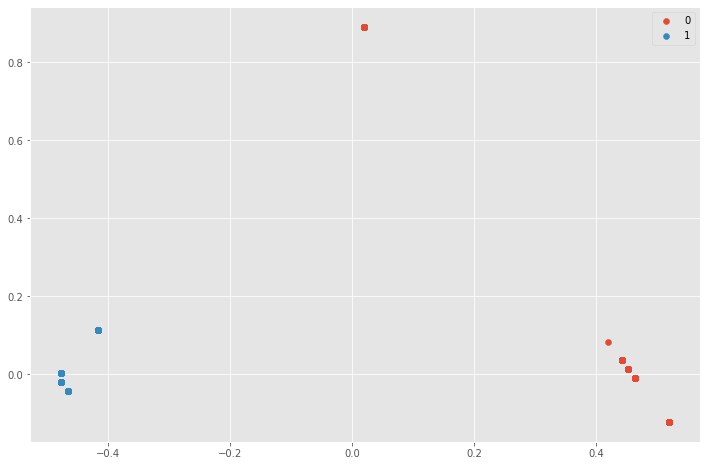

In [34]:
labels_ = np.unique(y_pred)
 
#plotting the results:
 
for i in labels_:
    plt.scatter(df_[y_pred == i , 0] , df_[y_pred == i , 1] , label = i)
plt.legend()
plt.show()

Task 4.5 - Aggregate the average satisfaction & experience score per cluster.

In [35]:
cluster_1 = satisfaction_df[satisfaction_df['class']==1]
cluster_2 = satisfaction_df[satisfaction_df['class']==0]
aggregate_cluster_1 = aggregation_cols(cluster_1,"satisfaction_score","experience_score","numerical")
aggregate_cluster_2 = aggregation_cols(cluster_2,"satisfaction_score","experience_score","numerical")

In [36]:
aggregate_cluster_1

,experience_score_min,experience_score_max,experience_score_mean
satisfaction_score,,,
0.424161,0.058826,0.058826,0.058826
0.424161,0.058826,0.058826,0.058826
0.424161,0.058826,0.058826,0.058826
0.424161,0.058826,0.058826,0.058826
0.424161,0.058826,0.058826,0.058826
...,...,...,...
0.479953,0.013829,0.013829,0.013829
0.479953,0.013829,0.013829,0.013829
0.479953,0.013829,0.013829,0.013829


In [37]:
satisfaction_df.to_csv("../data/satisfaction.csv")